## Molecule odor prediction via GINs with self-supervised contrastive pretraining



In [3]:
# toggle whether or not to use pretraining
use_pretraining = False

In [4]:
import torch
print("PyTorch has version {}".format(torch.__version__))
import torch_geometric
torch_geometric.__version__
import numpy as np

from torch_geometric.loader import DataLoader

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score
from tqdm import tqdm


import sys
sys.path.append('olf/GNNose/')
sys.path.append("GraphSSL/")


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed = 12345

torch_geometric.seed.seed_everything(seed)

PyTorch has version 1.13.1+cu117


In [5]:
# initialize model and finetune
from odor_model import ScentClassifier
from odor_train import train, test
from torch_ema import ExponentialMovingAverage

def run_finetuning(model, device, num_epochs, lr, weight_decay):
    """Train or finetune the given model using the train/val sets"""

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    ema = ExponentialMovingAverage(model.parameters(), decay=0.995)

    # track metrics
    roc_scores, f1_scores, accs, losses, val_losses = [], [], [], [], []

    for epoch in tqdm(range(num_epochs)):
        loss = train(model, optimizer, train_loader, 'train', device, weighted_BCE=True, ema=ema)
        val_loss = train(model, optimizer, val_loader, 'val', device, weighted_BCE=True)
        train_acc, train_preds, train_true  = test(model, train_loader, device)
        test_acc, test_preds, test_true = test(model, val_loader, device)

        # calculate bootstrapped ROC AUC score over entire val set
        _, whole_val_preds, whole_val_true = test(
            model, DataLoader(val_set, batch_size=len(val_set), shuffle=True), device)
        whole_val_preds = whole_val_preds.squeeze()
        whole_val_true = whole_val_true.squeeze()
        rocauc_score = roc_auc_score(whole_val_true.cpu(), whole_val_preds.cpu())
        f1 = f1_score(whole_val_true.cpu(), whole_val_preds.cpu())

        # track metrics
        roc_scores.append(rocauc_score)
        f1_scores.append(f1)
        accs.append(test_acc)
        losses.append(loss)
        val_losses.append(val_loss)

    best_f1_score = max(f1_scores)
    best_f1_epoch = f1_scores.index(best_f1_score)
    best_auc_score = max(roc_scores)
    best_auc_epoch = roc_scores.index(best_auc_score)

    # plot_losses(losses, val_losses, title='finetuning: train vs. val loss')
    # fig, ax = plt.subplots(1, 2, figsize=(6, 2))
    # for i, (name, metric) in enumerate([
    #     ('f1', f1_scores), ('roc', roc_scores)
    # ]):
    #     ax[i].plot(range(len(metric)), metric)
    #     ax[i].set_ylim((0, 1))
    #     ax[i].set_title(name)
    # plt.show()

    return best_f1_score, best_f1_epoch, best_auc_score, best_auc_epoch


In [6]:
# load and split the dataset

results = []

#done
# 'alcoholic','aldehydic','alliaceous','almond','ambergris','ambery', 'ambrette',
# 'animalic','anisic','apple','balsamic','banana','berry','blackcurrant',
# 'blueberry','body','bread','burnt','butter',cacao','camphor',
# 'caramellic','cedar','cheese','chemical','cherry','cinnamon','citrus',
# 'clean','clove','coconut','coffee','coniferous','cooked','cooling',
#  'cucumber', 'dairy','dry','earthy','ester','ethereal','fatty',
# 'fermented', 'floral','fresh','fruity', 'geranium','gourmand','grape',
# 'grapefruit', 'grass','green','herbal','honey','hyacinth','jasmin',
# 'lactonic','leaf','leather','lemon','lily','liquor','meat',
# 'medicinal', 'melon','metallic','mint','mushroom','musk','musty',
# 'nut', 'odorless', 'oily','orange','overripe', 'pear','pepper',
#  'phenolic','plastic','plum','powdery','pungent','rancid','resinous',
# 'ripe', 'roasted','rose','seafood','sharp','smoky','sour',
# 'spicy','sulfuric','sweet','syrup','terpenic','tobacco','tropicalfruit',
# 'vanilla','vegetable','violetflower','watery','waxy','whiteflower','wine',
# 'woody',ammoniac', 'cognac',

#not done
# 
odor_list = ["cognac","whiteflower","watery","violetflower","sweet","sharp"]

# odor_list = ["pungent","rose"]
from odor_data import get_graph_data

for odor in odor_list:
    print(odor)
    graph_list = get_graph_data('ol') # 'ol' for Dream Olfaction dataset
    
    
    
    
    train_set, val_set, test_set = torch.utils.data.random_split(graph_list, [0.9, 0.05, 0.05])
    
    batch_size = 128
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, drop_last=True)
    
    
    hidden_channels = 128
    num_layers = 2
    dropout_p = 0.25
    pooling_type = 'max'
    
    
    # set hyperparameters
    in_channels = list(graph_list[2].x.shape)[-1]
    print(in_channels)
    out_channels = 1
    
    
    
    
    if use_pretraining:
        from odor_pretrain import build_pretraining_loader, pretrain
        from odor_model import PretrainingGIN
    
        pretrain_epochs = 50
        pretrain_batch_size = 256
        pretrain_lr = 1e-3
        pretrain_weight_decay = 1e-4
    
        # We apply this approach using the GraphSSL GitHub repository.
        pretrain_train_loader = build_pretraining_loader(train_set, "train", batch_size=pretrain_batch_size)
        pretrain_val_loader = build_pretraining_loader(val_set, "val", batch_size=pretrain_batch_size)
    
    
    
    # apply pretraining
    if use_pretraining:
        pretrain_model = PretrainingGIN(
            in_channels,
            hidden_channels,
            num_layers,
            out_channels,
            dropout=dropout_p
        ).to(device)
    
        pretrain_optimizer = torch.optim.Adam(pretrain_model.parameters(), lr=pretrain_lr, weight_decay=pretrain_weight_decay)
    
        val_losses = []
        train_losses = []
        for epoch in (range(pretrain_epochs)):
            train_loss = pretrain(pretrain_model, pretrain_optimizer, epoch, "train", pretrain_train_loader, device)
            val_loss = pretrain(pretrain_model, pretrain_optimizer, epoch, "val", pretrain_val_loader, device)
            log = "Epoch {}, Train Loss: {:.3f}, Val Loss: {:.3f}"
            print(log.format(epoch, train_loss, val_loss))
    
            train_losses.append(train_loss)
            val_losses.append(val_loss)
    
        # plot_losses(train_losses, val_losses, "pretraining loss")
    
    num_epochs = 50
    lr = 1e-4
    weight_decay = 1e-3
    
    
    num_trials = 1
    dropout_p = 0.1
    trial_results = []
    
    for t in range(num_trials):
        model = ScentClassifier(
            in_channels,
            hidden_channels,
            num_layers,
            out_channels,
            dropout=dropout_p,
            pooling_type=pooling_type,
        )
        model = model.to(device)
    
        if use_pretraining:
            model.gnn.load_state_dict(
                pretrain_model.gnn.state_dict()
            )
    
        best_f1_score, best_f1_epoch, best_auc_score, best_auc_epoch = run_finetuning(model, device, num_epochs, lr, weight_decay)
        trial_results.append((best_f1_score, best_f1_epoch, best_auc_score, best_auc_epoch))
    
    
    hyperparam_tuning = True
    
    if hyperparam_tuning:
        import itertools
    
        param_search = {
            "lr": [1e-2, 5e-3, 1e-3],
            "weight_decay": [1e-5, 1e-6],
        }
    
        param_search_results = []
    
        for lr, weight_decay in list(itertools.product(*list(param_search.values()))):
            # create model
            model = ScentClassifier(
                in_channels,
                hidden_channels,
                num_layers,
                out_channels,
                dropout=dropout_p,
                pooling_type=pooling_type,
            )
            model = model.to(device)
    
            # load pretrained weights, if relevant
            if use_pretraining:
                model.gnn.load_state_dict(
                    pretrain_model.gnn.state_dict()
                )
    
            # train
            best_f1_score, best_f1_epoch, best_auc_score, best_auc_epoch = run_finetuning(
                model, device, num_epochs, lr, weight_decay)
    
            param_search_results.append(
                ((best_f1_score, best_f1_epoch, best_auc_score, best_auc_epoch), (lr, weight_decay))
            )
    if hyperparam_tuning:
        # show best results, by F1 or AUC
        param_search_results.sort(key = lambda x: x[0][0])
        print("Best F1 score:", param_search_results[-1][0][0])
        # print("Best F1 epoch:", param_search_results[-1][0][1])
        print(
            "Best F1 params:",
            dict(zip(
                param_search.keys(),
                param_search_results[-1][-1]
            ))
        )
        x  = param_search_results[-1][0][0]
        param_search_results.sort(key = lambda x: x[0][2])
        print("Best AUC score:", param_search_results[-1][0][2])
        # print("Best AUC epoch:", param_search_results[-1][0][3])
        print(
            "Best AUC params:",
            dict(zip(
                param_search.keys(),
                param_search_results[-1][-1]
            ))
        )
        results.append((odor,x,param_search_results[-1][0][2]))
        torch.save(model.state_dict(), '/home/nomam/workspace/research/base_model_3_12_2023_{0}.pth'.format(odor))

cognac


/home/nomam/workspace/research/cs224w-project/GNNose/odor_data.py:33: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  one_hot_encoded = one_hot_encoded.groupby(one_hot_encoded.columns, axis=1).sum()


12


  0%|                                                                                                                                                                                        | 0/50 [00:00<?, ?it/s]/home/nomam/.local/lib/python3.10/site-packages/torch_geometric/warnings.py:18: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
  0%|                                                                                                                                                                                        | 0/50 [00:01<?, ?it/s]


ValueError: Using a target size (torch.Size([13952])) that is different to the input size (torch.Size([128])) is deprecated. Please ensure they have the same size.

In [10]:
results

[('cognac', 0.13793103448275862, 0.941588785046729),
 ('whiteflower', 0.30769230769230765, 0.8145539906103285),
 ('watery', 0.18181818181818182, 0.7934272300469483),
 ('violetflower', 0.43478260869565216, 0.8639781271360218),
 ('sweet', 0.30769230769230765, 0.7064676616915422),
 ('sharp', 0.08333333333333333, 0.9488372093023255)]

In [2]:
from odor_data import get_graph_data
get_graph_data('ol')

/home/nomam/workspace/research/cs224w-project/GNNose/odor_data.py:33: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  one_hot_encoded = one_hot_encoded.groupby(one_hot_encoded.columns, axis=1).sum()


[Data(x=[14, 12], edge_index=[2, 28], edge_attr=[28, 3], smiles='C/C=C/C(=O)C1CCC(C=C1C)(C)C', y=[109]),
 Data(x=[6, 12], edge_index=[2, 10], edge_attr=[10, 3], smiles='COC(=O)OC', y=[109]),
 Data(x=[10, 12], edge_index=[2, 22], edge_attr=[22, 3], smiles='Cc1cc2c([nH]1)cccc2', y=[109]),
 Data(x=[17, 12], edge_index=[2, 34], edge_attr=[34, 3], smiles='C1CCCCCCCC(=O)CCCCCCC1', y=[109]),
 Data(x=[17, 12], edge_index=[2, 36], edge_attr=[36, 3], smiles='CC(CC(=O)OC1CC2C(C1(C)CC2)(C)C)C', y=[109]),
 Data(x=[9, 12], edge_index=[2, 16], edge_attr=[16, 3], smiles='CCC[C@H](CCO)SC', y=[109]),
 Data(x=[12, 12], edge_index=[2, 24], edge_attr=[24, 3], smiles='CC(C)C(=O)OCc1ccco1', y=[109]),
 Data(x=[16, 12], edge_index=[2, 36], edge_attr=[36, 3], smiles='OC[C@H]1[C@H]2CC[C@H]3[C@@]1(C)CCCC([C@@H]23)(C)C', y=[109]),
 Data(x=[14, 12], edge_index=[2, 28], edge_attr=[28, 3], smiles='CCc1ccc(cc1)CC(C=O)(C)C', y=[109]),
 Data(x=[16, 12], edge_index=[2, 34], edge_attr=[34, 3], smiles='CC(C)[C@@H]1CC[C@@](

### Installations

We install various dependencies.

In [7]:
# import torch
# print("PyTorch has version {}".format(torch.__version__))

# # !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
# # !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
# # !pip install git+https://github.com/pyg-team/pytorch_geometric.git
# # !pip install pyrfume
# # !pip install torch-ema

PyTorch has version 1.13.1+cu117


Load files with helpful modules from GitHub

In [ ]:
# !git clone https://github.com/paridhimaheshwari2708/GraphSSL.git
# !git clone https://github.com/mattyding/cs224w-project.git


In [ ]:
# import torch_geometric
# torch_geometric.__version__

In [8]:
# import numpy as np

# from torch_geometric.loader import DataLoader

# import matplotlib.pyplot as plt
# from sklearn.metrics import f1_score, roc_auc_score
# from tqdm import tqdm


# import sys
# sys.path.append('cs224w-project/GNNose/')
# sys.path.append("GraphSSL/")


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
torch.cuda.is_available()

True

Set random seeds so that results can be reproduced. Note PyG has an [issue with reproducibility](https://github.com/pyg-team/pytorch_geometric/issues/92) when using GPUs.

In [10]:
# seed = 12345

# torch_geometric.seed.seed_everything(seed)

### Load the Leffingwell odor dataset

Within `get_graph_data`, we add initial node features calculated by using atom features and pooling features from adjacent edges.

In [11]:
# # load and split the dataset
# from odor_data import get_graph_data

# graph_list = get_graph_data('ol') # 'ol' for Dream Olfaction dataset

/home/nomam/workspace/research/cs224w-project/GNNose/odor_data.py:33: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  one_hot_encoded = one_hot_encoded.groupby(one_hot_encoded.columns, axis=1).sum()


Observe an example graph in PyG format:

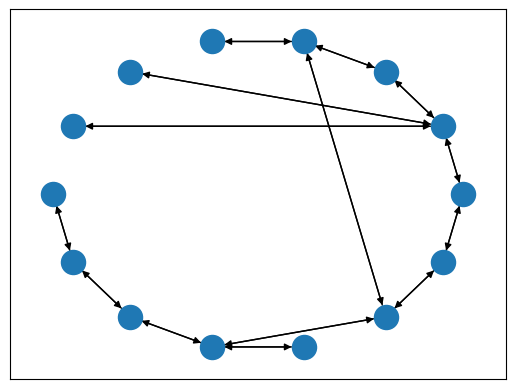

In [12]:
# from plot_utils import nx_draw_molecule
# nx_draw_molecule(graph_list[0].x, graph_list[0].edge_index)

We use a 70%, 10%, 20% train-val-test split

In [13]:
# train_set, val_set, test_set = torch.utils.data.random_split(graph_list, [0.9, 0.05, 0.05])

# batch_size = 128

# train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
# val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, drop_last=True)
# test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, drop_last=True)

### Choose model architecture hyperparameters

In [14]:
# hidden_channels = 128
# num_layers = 2
# dropout_p = 0.25
# pooling_type = 'max'

### Load the model

We define the `ScentClassifier` model in `odor_model`, which is a GIN with a max-pooling layer and classifier head.

In [15]:
# # set hyperparameters
# in_channels = list(graph_list[2].x.shape)[-1]
# print(in_channels)
# out_channels = 1

12


### Apply pretraining

In [16]:
# from plot_utils import plot_losses, plot_loss

In [17]:
# if use_pretraining:
#     from odor_pretrain import build_pretraining_loader, pretrain
#     from odor_model import PretrainingGIN

#     pretrain_epochs = 50
#     pretrain_batch_size = 256
#     pretrain_lr = 1e-3
#     pretrain_weight_decay = 1e-4

#     # We apply this approach using the GraphSSL GitHub repository.
#     pretrain_train_loader = build_pretraining_loader(train_set, "train", batch_size=pretrain_batch_size)
#     pretrain_val_loader = build_pretraining_loader(val_set, "val", batch_size=pretrain_batch_size)


In [18]:
# # apply pretraining
# if use_pretraining:
#     pretrain_model = PretrainingGIN(
#         in_channels,
#         hidden_channels,
#         num_layers,
#         out_channels,
#         dropout=dropout_p
#     ).to(device)

#     pretrain_optimizer = torch.optim.Adam(pretrain_model.parameters(), lr=pretrain_lr, weight_decay=pretrain_weight_decay)

#     val_losses = []
#     train_losses = []
#     for epoch in (range(pretrain_epochs)):
#         train_loss = pretrain(pretrain_model, pretrain_optimizer, epoch, "train", pretrain_train_loader, device)
#         val_loss = pretrain(pretrain_model, pretrain_optimizer, epoch, "val", pretrain_val_loader, device)
#         log = "Epoch {}, Train Loss: {:.3f}, Val Loss: {:.3f}"
#         print(log.format(epoch, train_loss, val_loss))

#         train_losses.append(train_loss)
#         val_losses.append(val_loss)

#     plot_losses(train_losses, val_losses, "pretraining loss")

### Fine-tune on labeled data

In [19]:
# num_epochs = 50
# lr = 1e-4
# weight_decay = 1e-3

In [22]:
# # initialize model and finetune
# from odor_model import ScentClassifier
# from odor_train import train, test
# from torch_ema import ExponentialMovingAverage

# # def run_finetuning(model, device, num_epochs, lr, weight_decay):
# #     """Train or finetune the given model using the train/val sets"""

# #     optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
# #     ema = ExponentialMovingAverage(model.parameters(), decay=0.995)

# #     # track metrics
# #     roc_scores, f1_scores, accs, losses, val_losses = [], [], [], [], []

# #     for epoch in tqdm(range(num_epochs)):
# #         loss = train(model, optimizer, train_loader, 'train', device, weighted_BCE=True, ema=ema)
# #         val_loss = train(model, optimizer, val_loader, 'val', device, weighted_BCE=True)
# #         train_acc, train_preds, train_true  = test(model, train_loader, device)
# #         test_acc, test_preds, test_true = test(model, val_loader, device)

# #         # calculate bootstrapped ROC AUC score over entire val set
# #         _, whole_val_preds, whole_val_true = test(
# #             model, DataLoader(val_set, batch_size=len(val_set), shuffle=True), device)
# #         whole_val_preds = whole_val_preds.squeeze()
# #         whole_val_true = whole_val_true.squeeze()
# #         rocauc_score = roc_auc_score(whole_val_true.cpu(), whole_val_preds.cpu())
# #         f1 = f1_score(whole_val_true.cpu(), whole_val_preds.cpu())

# #         # track metrics
# #         roc_scores.append(rocauc_score)
# #         f1_scores.append(f1)
# #         accs.append(test_acc)
# #         losses.append(loss)
# #         val_losses.append(val_loss)

# #     best_f1_score = max(f1_scores)
# #     best_f1_epoch = f1_scores.index(best_f1_score)
# #     best_auc_score = max(roc_scores)
# #     best_auc_epoch = roc_scores.index(best_auc_score)

# #     plot_losses(losses, val_losses, title='finetuning: train vs. val loss')
# #     fig, ax = plt.subplots(1, 2, figsize=(6, 2))
# #     for i, (name, metric) in enumerate([
# #         ('f1', f1_scores), ('roc', roc_scores)
# #     ]):
# #         ax[i].plot(range(len(metric)), metric)
# #         ax[i].set_ylim((0, 1))
# #         ax[i].set_title(name)
# #     plt.show()

# #     return best_f1_score, best_f1_epoch, best_auc_score, best_auc_epoch

# from sklearn.metrics import roc_auc_score, f1_score, multilabel_confusion_matrix

# def run_finetuning(model, device, num_epochs, lr, weight_decay):
#     """Train or finetune the given model using the train/val sets"""

#     optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
#     ema = ExponentialMovingAverage(model.parameters(), decay=0.995)

#     # track metrics
#     roc_scores, f1_scores, accs, losses, val_losses = [], [], [], [], []

#     for epoch in tqdm(range(num_epochs)):
#         loss = train(model, optimizer, train_loader, 'train', device, weighted_BCE=True, ema=ema)
#         val_loss = train(model, optimizer, val_loader, 'val', device, weighted_BCE=True)
#         train_preds, train_true = test(model, train_loader, device, multilabel=True)
#         test_preds, test_true = test(model, val_loader, device, multilabel=True)

#         # calculate ROC AUC score and F1 score
#         rocauc_score = roc_auc_score(train_true.cpu(), train_preds.cpu(), average='macro')
#         f1 = f1_score(train_true.cpu(), (train_preds > 0.5).cpu(), average='micro')

#         # track metrics
#         roc_scores.append(rocauc_score)
#         f1_scores.append(f1)
#         accs.append(test_acc)
#         losses.append(loss)
#         val_losses.append(val_loss)

#     best_f1_score = max(f1_scores)
#     best_f1_epoch = f1_scores.index(best_f1_score)
#     best_auc_score = max(roc_scores)
#     best_auc_epoch = roc_scores.index(best_auc_score)

#     plot_losses(losses, val_losses, title='finetuning: train vs. val loss')
#     fig, ax = plt.subplots(1, 2, figsize=(6, 2))
#     for i, (name, metric) in enumerate([
#         ('f1', f1_scores), ('roc', roc_scores)
#     ]):
#         ax[i].plot(range(len(metric)), metric)
#         ax[i].set_ylim((0, 1))
#         ax[i].set_title(name)
#     plt.show()

#     return best_f1_score, best_f1_epoch, best_auc_score, best_auc_epoch



In [ ]:
# num_trials = 1
# dropout_p = 0.1
# trial_results = []

# for t in range(num_trials):
#     model = ScentClassifier(
#         in_channels,
#         hidden_channels,
#         num_layers,
#         out_channels,
#         dropout=dropout_p,
#         pooling_type=pooling_type,
#     )
#     model = model.to(device)

#     if use_pretraining:
#         model.gnn.load_state_dict(
#             pretrain_model.gnn.state_dict()
#         )

#     best_f1_score, best_f1_epoch, best_auc_score, best_auc_epoch = run_finetuning(model, device, num_epochs, lr, weight_decay)
#     trial_results.append((best_f1_score, best_f1_epoch, best_auc_score, best_auc_epoch))

  0%|                                                                                                                                                                                        | 0/50 [00:00<?, ?it/s]


ValueError: Using a target size (torch.Size([13952])) that is different to the input size (torch.Size([128])) is deprecated. Please ensure they have the same size.

In [ ]:
trial_results

### Hyperparameter tuning (optional)

We can also perform a gridsearch to find optimal values for various hyperparameters.

In [ ]:
# hyperparam_tuning = True

In [ ]:
# if hyperparam_tuning:
#     import itertools

#     param_search = {
#         "lr": [1e-2, 5e-3, 1e-3],
#         "weight_decay": [1e-5, 1e-6],
#     }

#     param_search_results = []

#     for lr, weight_decay in list(itertools.product(*list(param_search.values()))):
#         # create model
#         model = ScentClassifier(
#             in_channels,
#             hidden_channels,
#             num_layers,
#             out_channels,
#             dropout=dropout_p,
#             pooling_type=pooling_type,
#         )
#         model = model.to(device)

#         # load pretrained weights, if relevant
#         if use_pretraining:
#             model.gnn.load_state_dict(
#                 pretrain_model.gnn.state_dict()
#             )

#         # train
#         best_f1_score, best_f1_epoch, best_auc_score, best_auc_epoch = run_finetuning(
#             model, device, num_epochs, lr, weight_decay)

#         param_search_results.append(
#             ((best_f1_score, best_f1_epoch, best_auc_score, best_auc_epoch), (lr, weight_decay))
#         )


In [ ]:
# if hyperparam_tuning:
#     # show best results, by F1 or AUC
#     param_search_results.sort(key = lambda x: x[0][0])
#     print("Best F1 score:", param_search_results[-1][0][0])
#     print("Best F1 epoch:", param_search_results[-1][0][1])
#     print(
#         "Best F1 params:",
#         dict(zip(
#             param_search.keys(),
#             param_search_results[-1][-1]
#         ))
#     )

#     param_search_results.sort(key = lambda x: x[0][2])
#     print("Best AUC score:", param_search_results[-1][0][2])
#     print("Best AUC epoch:", param_search_results[-1][0][3])
#     print(
#         "Best AUC params:",
#         dict(zip(
#             param_search.keys(),
#             param_search_results[-1][-1]
#         ))
#     )

### Visualize model embeddings

In [ ]:
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE

# def plot_embeddings(model, graph_list, title=None, savepath=None):
#     """Visualize model embeddings for graphs in graph_list via PCA and t-SNE."""
#     # look just at GNN + pooling
#     emb_model = PretrainingGIN(
#         in_channels,
#         hidden_channels,
#         num_layers,
#         out_channels,
#         dropout=dropout_p
#     ).to(device)

#     if model is not None:
#         print('loading state dict')
#         emb_model.gnn.load_state_dict(
#             model.gnn.state_dict()
#         )

#     # generate embeddings
#     coords = []
#     labels = []
#     for graph_data in graph_list:
#         graph_data = graph_data.to(device)
#         readout = emb_model(graph_data.x, graph_data.edge_index, batch=torch.tensor([0]).to(device))
#         coords.append(readout.squeeze().cpu())
#         labels.append(graph_data.y.item())

#     X = torch.vstack(coords).detach().numpy()

#     pca = PCA(n_components=30)
#     X_pca = pca.fit_transform(X)

#     X_embedded = TSNE(n_components=2).fit_transform(X_pca)

#     labels = np.array(labels)

#     plt.scatter(X_embedded[(labels==0), 0], X_embedded[(labels==0), 1], c='red', s=0.2, label='not pungent')
#     plt.scatter(X_embedded[(labels==1), 0], X_embedded[(labels==1), 1], c='blue', s=0.2, label='pungent')
#     plt.legend()
#     # plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=['red' if x else 'blue' for x in labels], s=0.2)
#     if title:
#         plt.title(title)

#     if savepath:
#         plt.savefig(savepath, dpi=300)
#     plt.show()
#     # visualize

In [ ]:
# if use_pretraining:
#   plot_embeddings(None, graph_list,
#                   title='t-SNE embedding visualization: before training',
#                   savepath=None)
#   plot_embeddings(model, graph_list,
#                   title='t-SNE embedding visualization: after training',
#                   savepath=None)

In [ ]:
# torch.save()
# torch.save(model.state_dict(), '/home/nomam/workspace/research/model_3_12_2023_pungent_77_8.pth')

### Explainability: Feature Importance

In [ ]:
# import random
# from rdkit import Chem

# from torch_geometric import explain
# from torch_geometric.explain import Explanation, Explainer, ModelConfig

In [ ]:
# # Explainer for node attributes
# # Node mask: individual atrributes (features)
#   # edge features are integrated into node freatures previously
# # Edge mask: for each edge object
# na_explainer = Explainer(
#     model,
#     algorithm=explain.algorithm.GNNExplainer(),
#     explanation_type="model",
#     model_config=ModelConfig(mode="binary_classification", task_level="graph", return_type="probs"),
#     node_mask_type="attributes",
#     edge_mask_type="object"
# )

In [ ]:
# # get explanations on the test set
# all_na_explanations = []
# for graph_idx in range(len(test_set)):
#   data = test_set[graph_idx]
#   x, edge_index = data.x, data.edge_index
#   na_explanation = na_explainer(x.to(device), edge_index.to(device), batch=torch.tensor([0]).to(device))
#   all_na_explanations.append(na_explanation)

In [ ]:
# # Get the mean of node attribtute importance across all graphs
# NODE_FEATURE_NUM = 9
# na_importance = torch.mean(torch.stack([torch.mean(e.node_mask, axis=0) for e in all_na_explanations]), axis=0)

In [ ]:
# # Plot node feature importance
# import matplotlib.pyplot as plt
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
# features = ['atomic_num', 'chirality', 'degree', 'formal_charge', 'num_hs', 'num_radical_electrons', 'hybridization', 'is_aromatic', 'is_in_ring']
# ax.bar(features, list(na_importance.cpu())[:9])

# plt.title("Node Feature Importance")
# plt.xlabel("Node Feature")
# plt.ylabel("Importance Score")
# plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

# plt.show()

In [ ]:
# # Plot edge feature importance
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
# features = ['bond_type', 'stereo', 'is_conjugated']
# ax.bar(features, list(na_importance.cpu())[9:])

# plt.title("Edge Feature Importance")
# plt.xlabel("Edge Feature")
# plt.ylabel("Importance Score")
# plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

# plt.show()

### Explainability: Structural Importance

In [ ]:
# # Explainer for edge structure
# # Node mask: for each node object
# # Edge mask: for each edge object
# ob_explainer = Explainer(
#     model,
#     algorithm=explain.algorithm.GNNExplainer(),
#     explanation_type="model",
#     model_config=ModelConfig(mode="binary_classification", task_level="graph", return_type="probs"),
#     node_mask_type="object",
#     edge_mask_type="object"
# )

In [ ]:
# # get explanations for all of test set
# all_ob_explanations = []
# for graph_idx in range(len(test_set)):
#   data = test_set[graph_idx]
#   x, edge_index = data.x, data.edge_index
#   ob_explanation = ob_explainer(x.to(device), edge_index.to(device), batch=torch.tensor([0]).to(device))
#   all_ob_explanations.append(ob_explanation)

In [ ]:
# # Visualization
# from pickle import NONE
# from rdkit.Chem.Draw import rdMolDraw2D
# from rdkit.Chem import rdDepictor
# from matplotlib import colors
# from rdkit.Chem.Draw import IPythonConsole
# from IPython.display import SVG

# # Assign colors to nodes with higher than average scores
# def atom_col(atom_imp):
#   col = {}
#   threshold = torch.mean(atom_imp)
#   for i, imp in enumerate(atom_imp):
#     if imp > threshold:
#       col[i] = colors.to_rgb("#1BBC9B")
#     else:
#       col[i] = colors.to_rgb('#D3D3D3')
#   return col

# # Assign colors to edges with higher than average scores
# def bond_col(mol, bond_imp, edge_id, threshold=0.5):
#   col = {}
#   threshold = sum(bond_imp) / len(bond_imp)
#   for idx, bond in enumerate(mol.GetBonds()):
#       i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
#       i, j = min(i, j), max(i, j)
#       imp = bond_imp[edge_id.index((i, j))]
#       if imp > threshold:
#         col[i] = colors.to_rgb("#F06060")
#       else:
#         col[i] = colors.to_rgb('#D3D3D3')
#   return col

# # Generate visualization for an atom
# def visualize_molecule_explanation(dataset, graph_idx):
#   data = dataset[graph_idx]
#   x, edge_index = data.x, data.edge_index
#   ob_explanation = ob_explainer(x.to(device), edge_index.to(device), batch=torch.tensor([0]).to(device))
#   atom_imp = ob_explanation.node_mask
#   bond_imp = []
#   edge_idx = []
#   # average the two "directional" edges for score of undirected edge
#   for i in range(len(ob_explanation.edge_mask)):
#     a, b = ob_explanation.edge_index[0][i].cpu(), ob_explanation.edge_index[1][i].cpu()
#     if a < b:
#       edge_idx.append((a, b))
#       temp = NONE
#       for i in range(len(edge_index[0])):
#         if edge_index[0][i].item() == b.item() and edge_index[1][i].item() == a.item():
#           temp = i
#           break
#       bond_imp.append((ob_explanation.edge_mask[i]+ob_explanation.edge_mask[temp])/2)
#   mol = Chem.MolFromSmiles(data.smiles)
#   cp = Chem.Mol(mol)
#   # generate colors according to importance scores
#   highlightAtomColors = atom_col(atom_imp)
#   highlightAtoms = list(highlightAtomColors.keys())
#   highlightBondColors = bond_col(mol, bond_imp, edge_idx)
#   highlightBonds = list(highlightBondColors.keys())

#   # draw image
#   image_width, image_height = 400, 200
#   rdDepictor.Compute2DCoords(cp, canonOrient=True)
#   drawer = rdMolDraw2D.MolDraw2DCairo(image_width, image_height)
#   drawer.drawOptions().useBWAtomPalette()
#   drawer.DrawMolecule(
#       cp,
#       highlightAtoms=highlightAtoms,
#       highlightAtomColors=highlightAtomColors,
#       highlightBonds=highlightBonds,
#       highlightBondColors=highlightBondColors,
#   )
#   drawer.FinishDrawing()
#   drawer.WriteDrawingText(f"{graph_idx}.png")


In [ ]:
# # 5 random visualizations
# idx = random.sample(range(len(test_set)), 5)
# for i in idx:
#   visualize_molecule_explanation(test_set, i)

Note: to view the visualizations, click on the "Files" tab on the left and download the respective png files.